# 0200 ランダムフォレスト回帰
- ノンパラメトリックな手法（対象のデータ分布を仮定しない）
- カテゴリカルデータにも強い
- 多変数が複雑に関連し合っている場合、単純な線形モデルよりも決定木モデルのほうが精度が高い場合がある。
- 特に、変数同士の非線形な関係を捉えやすく、交互作用の検出力高

ただし、
- モデルの複雑性が増す
- ハイパーパラメータがブラックボックス化しやすい

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from constants import *

plt.style.use('ggplot')
sns.set_palette('flare')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. データ取得

In [26]:
raw_data = pd.read_csv(os.path.join(RAW_PATH, 'train.csv'), index_col=0)
raw_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### RFR用にデータを整形
順序・名義尺度はダミー変数化するため、基本的な特徴量のみ作成。
#### 元のデータセットから残すカラムを指定

In [27]:
all_data = pd.DataFrame()

raw_data['log_price'] = np.log(raw_data['SalePrice'])

all_data['MSSubClass'] = raw_data['MSSubClass'].astype(str)

all_data['log_price'] = raw_data['log_price']

all_data['total_sf'] = raw_data['1stFlrSF'] + raw_data['2ndFlrSF'].fillna(0) + raw_data['TotalBsmtSF'].fillna(0)

all_data['log_total_sf'] = np.log(all_data['total_sf'])

# フラグも作成
all_data['has_2nd'] = (raw_data['2ndFlrSF'] > 0).astype(int)

all_data['has_bsmt'] = (raw_data['TotalBsmtSF'] > 0).astype(int)

all_data['has_garage'] = (raw_data['GarageArea'] > 0).astype(int)

all_data['has_pool'] = (raw_data['PoolArea'] > 0).astype(int)

all_data['has_central_air'] = (raw_data['CentralAir'] == 'Y').astype(int)

all_data['has_fireplace'] = (raw_data['Fireplaces'] > 0).astype(int)

all_data['house_age'] = raw_data['YrSold'] - raw_data['YearBuilt']

all_data['remod_age'] = raw_data['YrSold'] - raw_data['YearRemodAdd']

all_data['total_porch_sf'] = raw_data['OpenPorchSF'] + raw_data['EnclosedPorch'].fillna(0) + raw_data['3SsnPorch'].fillna(0) + raw_data['ScreenPorch'].fillna(0)

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1460 non-null   object 
 1   log_price        1460 non-null   float64
 2   total_sf         1460 non-null   int64  
 3   log_total_sf     1460 non-null   float64
 4   has_2nd          1460 non-null   int64  
 5   has_bsmt         1460 non-null   int64  
 6   has_garage       1460 non-null   int64  
 7   has_pool         1460 non-null   int64  
 8   has_central_air  1460 non-null   int64  
 9   has_fireplace    1460 non-null   int64  
 10  house_age        1460 non-null   int64  
 11  remod_age        1460 non-null   int64  
 12  total_porch_sf   1460 non-null   int64  
dtypes: float64(2), int64(10), object(1)
memory usage: 159.7+ KB


In [28]:

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

neighbor_log_price = raw_data.groupby('Neighborhood')['log_price'].mean().sort_values(ascending=False)
neighbor_log_price_stdsclaled = std_scaler.fit_transform(neighbor_log_price.values.reshape(-1, 1))
neighbor_log_price_dict = dict(zip(neighbor_log_price.index, neighbor_log_price_stdsclaled))
all_data['neighbor_weight'] = raw_data['Neighborhood'].map(neighbor_log_price_dict).astype(float)

In [29]:
year_price = raw_data.groupby('YearBuilt')['SalePrice'].mean()
year_price = year_price.rolling(window=5, center=True).mean()
year_price = year_price.interpolate(method='linear')
year_price = year_price.fillna(raw_data.groupby('YearBuilt')['SalePrice'].mean())
all_data['year_price'] = raw_data['YearBuilt'].map(year_price)

all_data.drop(['total_sf'], axis=1, inplace=True)

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1460 non-null   object 
 1   log_price        1460 non-null   float64
 2   log_total_sf     1460 non-null   float64
 3   has_2nd          1460 non-null   int64  
 4   has_bsmt         1460 non-null   int64  
 5   has_garage       1460 non-null   int64  
 6   has_pool         1460 non-null   int64  
 7   has_central_air  1460 non-null   int64  
 8   has_fireplace    1460 non-null   int64  
 9   house_age        1460 non-null   int64  
 10  remod_age        1460 non-null   int64  
 11  total_porch_sf   1460 non-null   int64  
 12  neighbor_weight  1460 non-null   float64
 13  year_price       1460 non-null   float64
dtypes: float64(4), int64(9), object(1)
memory usage: 171.1+ KB


#### 生のデータから直接使うもの、one-hotエンコーディングするもの

In [30]:

cols = [
'MSZoning', 'OverallQual', 'OverallCond',
'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
'KitchenQual', 'Utilities', 'PoolQC', 'Functional', 
'GarageCars', 'GarageQual','GarageCond', 'LotFrontage'
]

all_data[cols] = raw_data[cols]

In [31]:
# 欠損値処理
all_data['LotFrontage'].fillna(0.0, inplace=True)
all_data['Utilities'].fillna('None', inplace=True)
all_data['KitchenQual'].fillna('TA', inplace=True)
all_data['Functional'].fillna('None', inplace=True)
all_data['GarageCars'].fillna(0, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1460 non-null   object 
 1   log_price        1460 non-null   float64
 2   log_total_sf     1460 non-null   float64
 3   has_2nd          1460 non-null   int64  
 4   has_bsmt         1460 non-null   int64  
 5   has_garage       1460 non-null   int64  
 6   has_pool         1460 non-null   int64  
 7   has_central_air  1460 non-null   int64  
 8   has_fireplace    1460 non-null   int64  
 9   house_age        1460 non-null   int64  
 10  remod_age        1460 non-null   int64  
 11  total_porch_sf   1460 non-null   int64  
 12  neighbor_weight  1460 non-null   float64
 13  year_price       1460 non-null   float64
 14  MSZoning         1460 non-null   object 
 15  OverallQual      1460 non-null   int64  
 16  OverallCond      1460 non-null   int64  
 17  ExterQual        14

/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_91592/1937394668.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/rk/9smfwdqx2cvdqr4qd3693stc0000gn/T/ipykernel_91592/1937394668.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [32]:
data = pd.get_dummies(all_data, drop_first=True, dtype=int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   log_price         1460 non-null   float64
 1   log_total_sf      1460 non-null   float64
 2   has_2nd           1460 non-null   int64  
 3   has_bsmt          1460 non-null   int64  
 4   has_garage        1460 non-null   int64  
 5   has_pool          1460 non-null   int64  
 6   has_central_air   1460 non-null   int64  
 7   has_fireplace     1460 non-null   int64  
 8   house_age         1460 non-null   int64  
 9   remod_age         1460 non-null   int64  
 10  total_porch_sf    1460 non-null   int64  
 11  neighbor_weight   1460 non-null   float64
 12  year_price        1460 non-null   float64
 13  OverallQual       1460 non-null   int64  
 14  OverallCond       1460 non-null   int64  
 15  GarageCars        1460 non-null   int64  
 16  LotFrontage       1460 non-null   float64
 17  

## 1. 単純なRFR実装
まずは、全ての変数を単純なランダムフォレスト回帰に入れ込んで予測してみる

In [33]:
from sklearn.model_selection import train_test_split

X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

test_rfr = RandomForestRegressor(random_state=0, n_jobs=-1)
test_rfr.fit(X_train, y_train)

y_pred = test_rfr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Test RFR')
print(f'  RMSE: {rmse:.4f}')
print(f'  R2: {r2:.4f}')

Test RFR
  RMSE: 0.1176
  R2: 0.8932


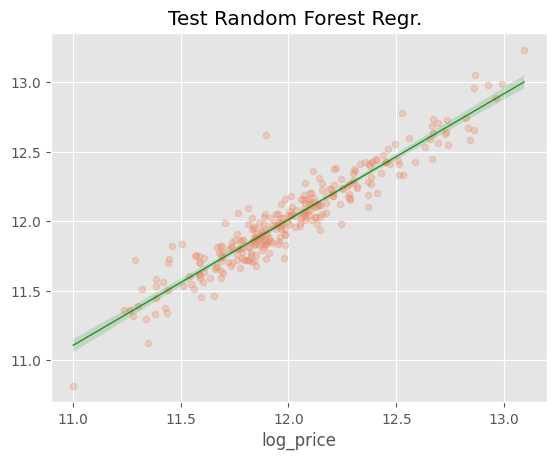

In [35]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Test Random Forest Regr. ")
plt.savefig(os.path.join(IMAGE_PATH, '0200_test_rfr.png'))
plt.show()

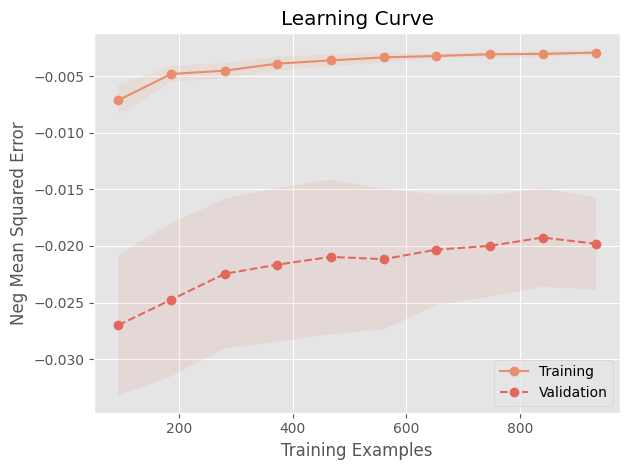

In [36]:
from utils import plot_learning_curve

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

plot_learning_curve(RandomForestRegressor(n_jobs=-1), X_train, y_train)
plt.savefig(os.path.join(IMAGE_PATH, '0201_learning_curve.png'))
plt.show()

#### 明らかに過学習
特徴量の重要度を測定する。

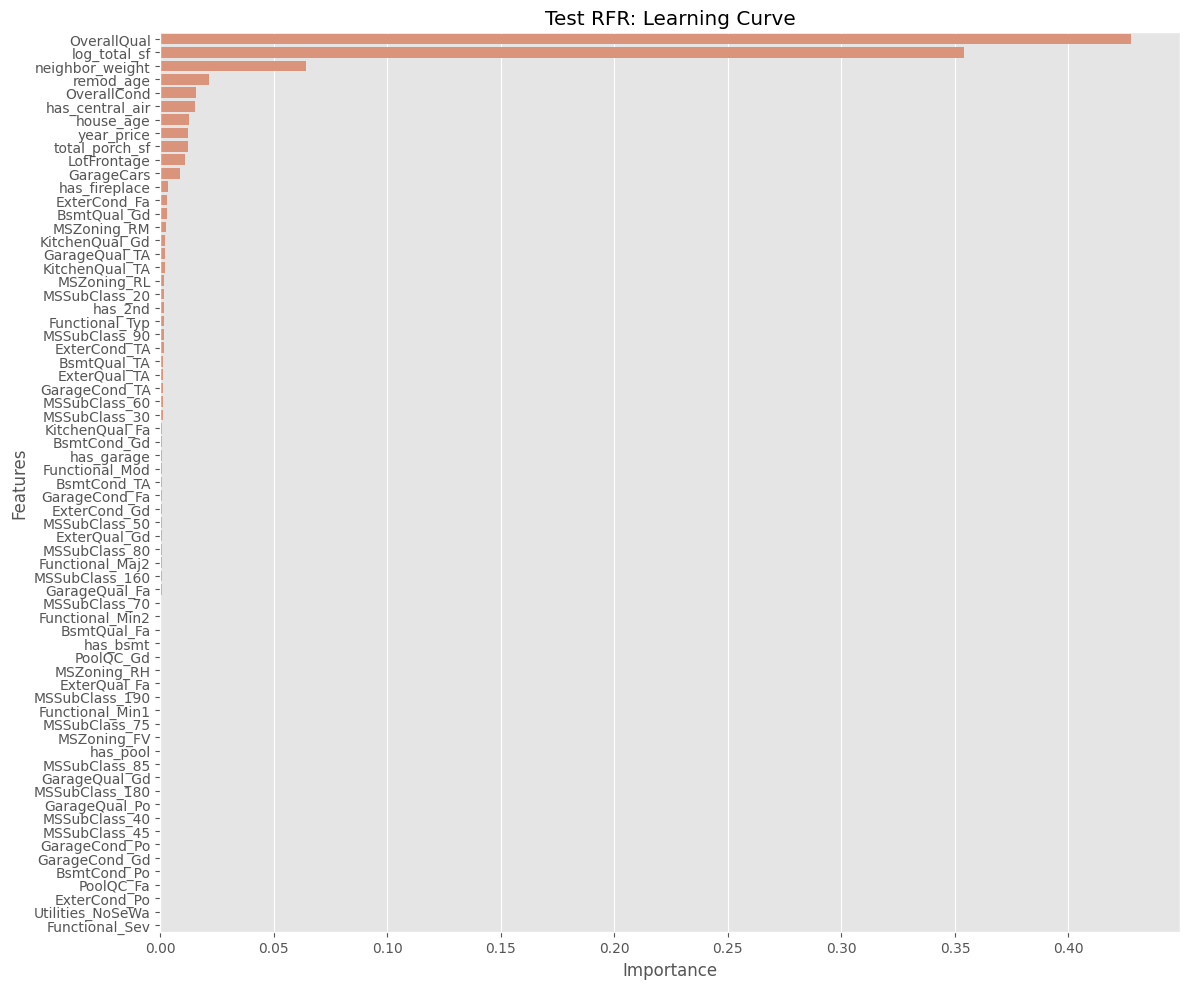

In [37]:
plt.figure(figsize=(12, 10))
feature_importances = test_rfr.feature_importances_

importance = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
sns.barplot(x='importance', y='feature', data=importance)
        
# 軸ラベルとタイトル
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Test RFR: Learning Curve')
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_PATH, '0202_test_rfr_lc.png'))
plt.show()

## 2. Optunaによるハイパーパラメータチューニング

In [38]:
import optuna

X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', [None, 'log2', 'sqrt', X_train.shape[1]//2, X_train.shape[1]//3]),
        }
    
    rfr = RandomForestRegressor(
        **params,
        n_jobs=-1,
        )
    
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [39]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300, n_jobs=-1)

[I 2025-05-19 11:41:02,431] A new study created in memory with name: no-name-1eb43a00-e06b-4e4f-9c00-18fc4ec77118
[I 2025-05-19 11:41:02,863] Trial 3 finished with value: 0.15537347661972953 and parameters: {'n_estimators': 18, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.15537347661972953.
[I 2025-05-19 11:41:02,906] Trial 4 finished with value: 0.15170466022485488 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 33}. Best is trial 4 with value: 0.15170466022485488.
[I 2025-05-19 11:41:02,916] Trial 7 finished with value: 0.17264403678409485 and parameters: {'n_estimators': 25, 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.15170466022485488.
[I 2025-05-19 11:41:02,923] Trial 0 finished with value: 0.18531455018659326 and parameters: {'n_estimators': 66, 'max_depth': 6, 'min_

In [40]:
study.best_params, study.best_value

({'n_estimators': 78,
  'max_depth': 29,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 22},
 0.1449782382944296)

In [41]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_samples_split (IntDistribution):
                                0.011502713615356023<extra></extra>, n_estimators
                                (IntDistribution):
                                0.017761935211428995<extra></extra>,
                                min_samples_leaf (IntDistribution):
                                0.04625590314856167<extra></extra>, max_features
                                (CategoricalDistribution):
                                0.25896719590662<extra></extra>, max_depth
                                (IntDistribution):
                                0.6655122521180333<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.01, 0.02, 0.05, 0.26, 0.67],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.011502713615356023, 0.017761935211428995,
                    0.04625590314856167, 0.25896719590662, 0.6655122521180333],
              'y': [min_samples_split, n_estimators, min_samples_leaf,
                    max_features, max_depth]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [42]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 297, 298, 299],
              'y': [0.18531455018659326, 0.17008710246274594, 0.17369149372426396,
                    ..., 0.14959768284949676, 0.14876190907045747,
                    0.14968377792442544]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 297, 298, 299],
              'y': [0.18531455018659326, 0.17008710246274594, 0.17008710246274594,
                    ..., 0.1449782382944296, 0.1449782382944296,
                    0.1449782382944296]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

best_params = study.best_params

best_rfr = RandomForestRegressor(**best_params, n_jobs=-1)
best_rfr.fit(X_train, y_train)
y_pred = best_rfr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Best RFR')
print(f'  RMSE: {round(rmse, 4)}')
print(f'  R2: {round(r2, 4)}')

Best RFR
  RMSE: 0.139
  R2: 0.8683


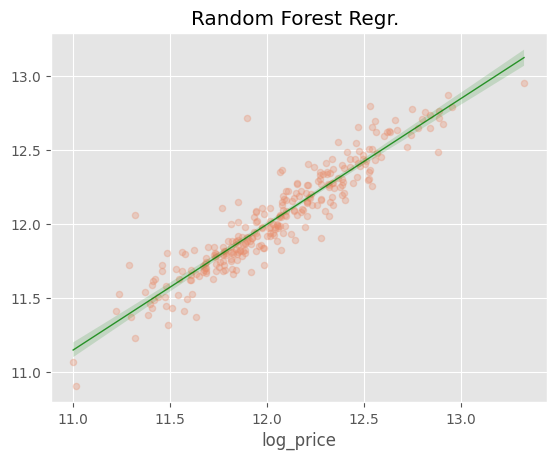

In [44]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Random Forest Regr. ")
plt.show()

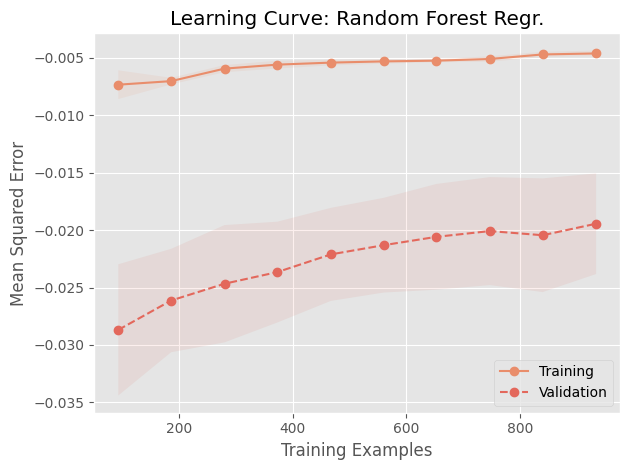

In [21]:
from utils import plot_learning_curve

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

val_rfr = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=2)

plot_learning_curve(val_rfr, X_train, y_train, title="Learning Curve: Random Forest Regr.")
plt.savefig(os.path.join(IMAGE_PATH, '0203_rfr_learning_curve.png'))
plt.show()

In [22]:
metrics = {
    'model': 'RFR',
    'params': f'{study.best_params}',
    'RMSE': round(rmse, 4),
    'R2': round(r2, 4)
}

metrics = pd.DataFrame(metrics, index=[0])

ridge_metrics = pd.read_csv(os.path.join(METRICS_PATH, '0100_metrics.csv'), index_col=0)

metrics = pd.concat([ridge_metrics, metrics])

metrics.to_csv(os.path.join(METRICS_PATH, '0200_metrics.csv'))

In [23]:
data.to_csv(os.path.join(RAW_PATH, '0200_data.csv'))

In [24]:
import joblib

joblib.dump(best_rfr, os.path.join(MODEL_PATH, '0200_rf_regr.joblib'))

['/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/models/0200_rf_regr.joblib']